# Part1: Popularity Prediction

## Problem 1.1

In [1]:
import json
import matplotlib.pyplot as plt

In [2]:
def plot_histogram(time_tweet, hashtag):
    hourly_tweet_count = [0] * int((max(time_tweet)-min(time_tweet))/3600+1)
    start_time = min(time_tweet)
    for time_stamp in time_tweet:
        hourly_tweet_count[int((time_stamp-start_time)/3600)] += 1
           
    plt.figure(figsize = (12,8))
    plt.bar([i for i in range(0,len(hourly_tweet_count))], hourly_tweet_count, 1, align='edge', color = 'k')
    hours_passed = float(max(time_tweet)-min(time_tweet))/3600.0
    plt.axis([0,hours_passed+1,0,int(max(hourly_tweet_count)*1.03)])
    plt.xlabel('Time(Hour)', fontsize = 15)
    plt.ylabel('Number of Tweets', fontsize = 15)
    plt.title('Number of Tweets over Time (' + hashtag + ')', fontsize = 20)
    plt.show()   
    
def stat_hashtag(hashtag):
    hashtag_dict = {'#GoHawks' : 'tweet_data/tweets_#gohawks.txt',
                    '#GoPatriots' : 'tweet_data/tweets_#gopatriots.txt',
                    '#NFL' : 'tweet_data/tweets_#nfl.txt',
                    '#Patriots' : 'tweet_data/tweets_#patriots.txt',
                    '#SB49' : 'tweet_data/tweets_#sb49.txt',
                    '#SuperBowl' : 'tweet_data/tweets_#superbowl.txt'}
    time_tweet = []
    num_retweets = []
    num_followers = []
   
    #import files
    with open(hashtag_dict[hashtag],encoding='utf-8') as input_file:
        for line in input_file:
            data = json.loads(line)
            time_tweet.append(data['citation_date'])
            num_retweets.append(data['metrics']['citations']['total'])
            num_followers.append(data['author']['followers'])
            
        input_file.close()
    #calculate the statistics
     #Average number of tweets per hour
    totnum_tweets = float(len(time_tweet))
    hour_passed = float(max(time_tweet)-min(time_tweet))/3600.0
    avenum_tweets = totnum_tweets/hour_passed
     #Average number of followers of users posting the tweets
    avenum_followers = float(sum(num_followers))/float(len(num_followers))
     #Average number of the retweets
    totnum_retweets = float(sum(num_retweets))
    avenum_retweets = totnum_retweets/totnum_tweets
    
    #print results
    print('\n')
    print('Statistics for', hashtag)
    print('Total number of the tweets', totnum_tweets)
    print('Average number of tweets per hour', avenum_tweets)
    print('Average number of followers of users posting the tweets', avenum_followers)
    print('Average number of the retweets', avenum_retweets)
    
    if hashtag in ['#NFL', '#SuperBowl']:
        plot_histogram(time_tweet, hashtag)



Statistics for #GoHawks
Total number of the tweets 188136.0
Average number of tweets per hour 325.37159130433116
Average number of followers of users posting the tweets 2203.931767444827
Average number of the retweets 2.014617085512608


Statistics for #GoPatriots
Total number of the tweets 26232.0
Average number of tweets per hour 45.69451057356203
Average number of followers of users posting the tweets 1401.8955093016164
Average number of the retweets 1.4000838670326319


Statistics for #NFL
Total number of the tweets 259024.0
Average number of tweets per hour 441.3234311373958
Average number of followers of users posting the tweets 4653.252285502502
Average number of the retweets 1.5385331089011056


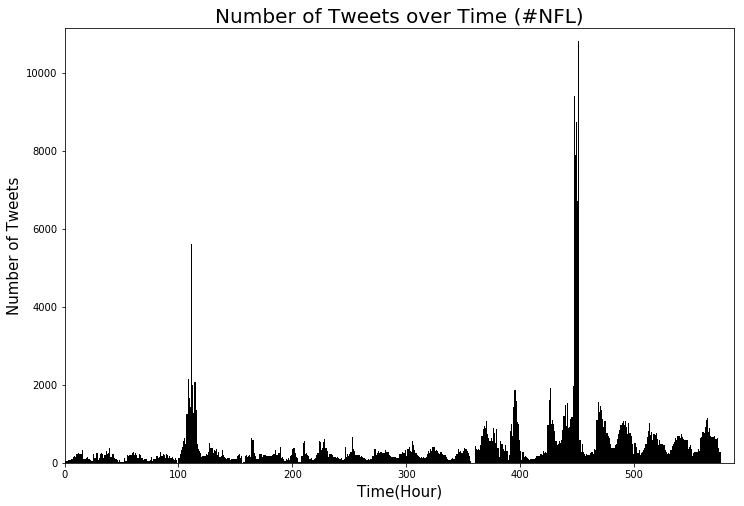



Statistics for #Patriots
Total number of the tweets 489713.0
Average number of tweets per hour 834.5555091641886
Average number of followers of users posting the tweets 3309.978828415827
Average number of the retweets 1.7828156491659402


Statistics for #SB49
Total number of the tweets 826951.0
Average number of tweets per hour 1419.8879074871902
Average number of followers of users posting the tweets 10267.31684948685
Average number of the retweets 2.5111487863247035


Statistics for #SuperBowl
Total number of the tweets 1348767.0
Average number of tweets per hour 2302.5004018833274
Average number of followers of users posting the tweets 8858.974662784603
Average number of the retweets 2.3882723999030224


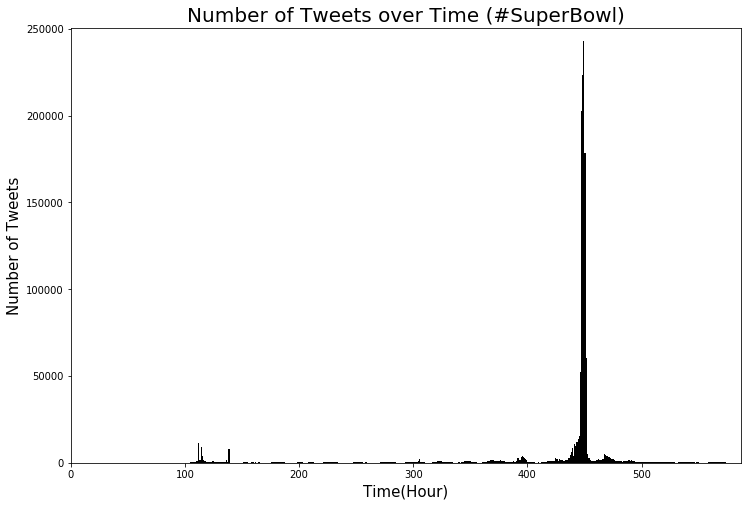

In [3]:
stat_hashtag('#GoHawks')
stat_hashtag('#GoPatriots')
stat_hashtag('#NFL')
stat_hashtag('#Patriots')
stat_hashtag('#SB49')
stat_hashtag('#SuperBowl')

## Problem 1.2

In [8]:
import os
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [9]:
def extract_information(hashtag):
    hashtag_dict = {'#GoHawks' : 'tweet_data/tweets_#gohawks.txt',
                    '#GoPatriots' : 'tweet_data/tweets_#gopatriots.txt',
                    '#NFL' : 'tweet_data/tweets_#nfl.txt',
                    '#Patriots' : 'tweet_data/tweets_#patriots.txt',
                    '#SB49' : 'tweet_data/tweets_#sb49.txt',
                    '#SuperBowl' : 'tweet_data/tweets_#superbowl.txt'}
    time_tweet = []
    num_retweets = []
    num_followers = []

    #hashtag = '#GoPatriots'
    #import files
    with open(hashtag_dict[hashtag],encoding='utf-8') as input_file:
        for line in input_file:
            data = json.loads(line)
            time_tweet.append(data['citation_date'])
            num_retweets.append(data['metrics']['citations']['total'])
            num_followers.append(data['author']['followers'])

            author_name = data['author']['nick']
            original_author_name = data['original_author']['nick']
            if author_name != original_author_name:
                num_retweets.append(True)
            else:
                num_retweets.append(False)

        input_file.close()

    # extract features
    hours_passed = int((max(time_tweet)-min(time_tweet))/3600)+1
    hourly_num_tweets = [0] * hours_passed
    hourly_num_retweets = [0] * hours_passed
    hourly_tot_followers = [0] * hours_passed
    hourly_maxnum_followers = [0] * hours_passed
    hourly_time_day = [0] * hours_passed
    totnum_tweets = float(len(time_tweet))

    start_time = min(time_tweet)
    for i in range(int(totnum_tweets)):
        current_hour = int((time_tweet[i]-start_time)/3600)

        hourly_num_tweets[current_hour] += 1
        if num_retweets[i]:
            hourly_num_retweets[current_hour] += 1

        hourly_tot_followers[current_hour] += num_followers[i]

        if num_followers[i] > hourly_maxnum_followers[current_hour]:
            hourly_maxnum_followers[current_hour] = num_followers[i]

    for i in range(len(hourly_time_day)):
        hourly_time_day[i] = i%24

    target_value = hourly_num_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_num_tweets,
                     hourly_num_retweets,
                     hourly_tot_followers,
                     hourly_maxnum_followers,
                     hourly_time_day,
                     target_value])
    data = np.transpose(data)
    df = DataFrame(data)
    df.columns = ['num_tweets', 
                  'num_retweets', 
                  'sum_followers',
                  'max_followers',
                  'time_of_the_day',
                  'target_value']
    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')
    df.to_csv('./Extracted_data/Q2_'+hashtag+'.csv', index = False)   

In [10]:
def calculate_linear_regression(hashtag):
    training_data = pd.read_csv('./Extracted_data/Q2_'+hashtag+'.csv')

    target_data = training_data.pop('target_value')

    lin_reg = LinearRegression(fit_intercept = False)
    lin_reg_result = lin_reg.fit(training_data, target_data)

    print(lin_reg.coef_)
    print(lin_reg.intercept_)

    predicted_values = lin_reg_result.predict(training_data)
    print('RMSE: ',mean_squared_error(target_data, predicted_values)**0.5)

    #Plot scattered figure
    fig, ax = plt.subplots()
    ax.scatter(target_data, predicted_values)
    ax.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()], 'k--', lw = 4)
    ax.set_xlabel('Actual values', fontsize = 10)
    ax.set_ylabel('Predicted value', fontsize = 10)
    plt.title('Fitted values vs. Actual values ('+hashtag+')', fontsize = 15)
    plt.figure(figsize = (10,10))
    plt.show()

    plt.clf
    fig, ax = plt.subplots()
    ax.scatter(target_data, (predicted_values - target_data)/target_data)
    ax.plot([0,max(target_data)], [0,0], 'k--', lw = 4)
    ax.set_xlabel('Actual values', fontsize = 10)
    ax.set_ylabel('Relative Error', fontsize = 10)
    plt.title('Relative Error vs. Actual values ('+hashtag+')', fontsize = 15)

    plt.figure(figsize = (10,10))
    plt.show()

    #Perform t-test and p-value
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

    A = np.identity(len(results.params))
    A = A[1:,:]
    print(results.f_test(A))

def linear_regression(hashtag):
    print('\n')
    print(hashtag)
    extract_information(hashtag)
    calculate_linear_regression(hashtag)



#GoHawks
[ 1.47834123e+00 -2.06892515e+01 -3.06303107e-04  2.59170117e-04
  7.43739153e+00]
0.0
RMSE:  938.8329310698986


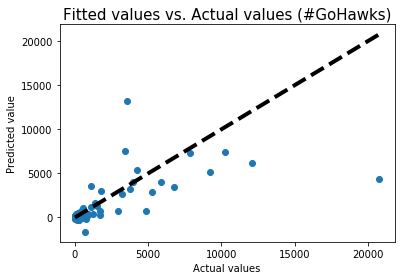

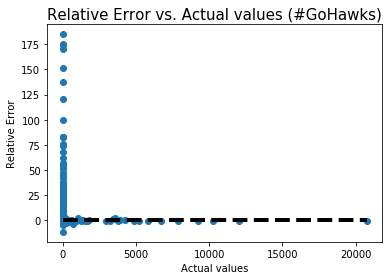

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     129.9
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           6.76e-92
Time:                        22:53:26   Log-Likelihood:                -4784.6
No. Observations:                 579   AIC:                             9579.
Df Residuals:                     574   BIC:                             9601.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          1.4783      0.162     

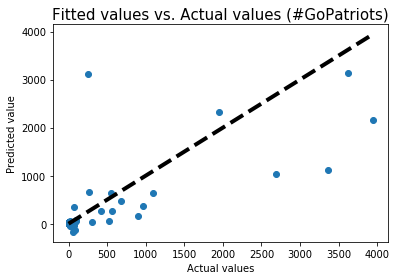

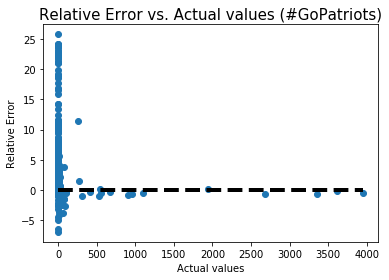

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     180.8
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          4.41e-115
Time:                        22:53:30   Log-Likelihood:                -3843.8
No. Observations:                 575   AIC:                             7698.
Df Residuals:                     570   BIC:                             7719.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          0.2548      0.202     

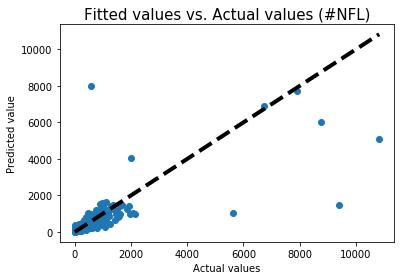

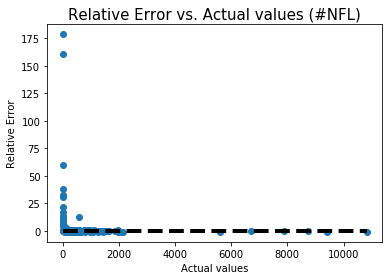

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     209.1
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          2.18e-127
Time:                        22:53:57   Log-Likelihood:                -4576.8
No. Observations:                 587   AIC:                             9164.
Df Residuals:                     582   BIC:                             9186.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          0.5273      0.102     

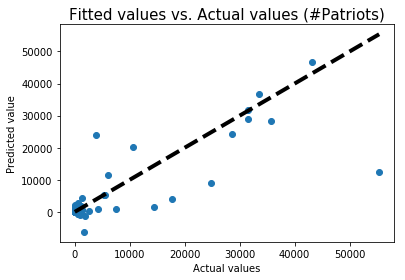

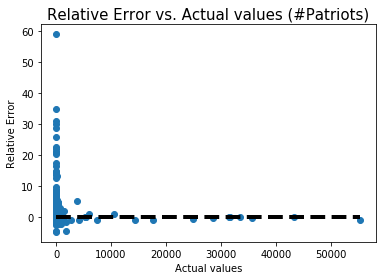

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     298.9
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          4.14e-158
Time:                        22:54:36   Log-Likelihood:                -5390.9
No. Observations:                 587   AIC:                         1.079e+04
Df Residuals:                     582   BIC:                         1.081e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          0.8210      0.039     

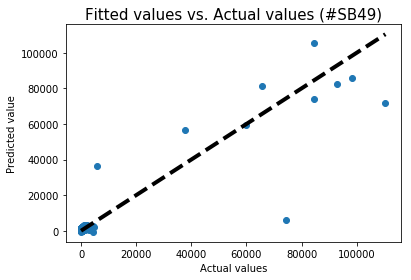

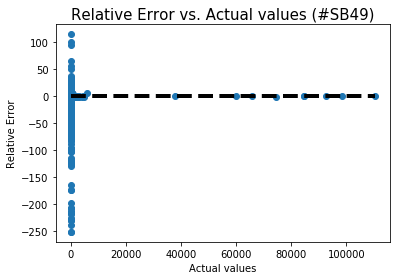

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     674.7
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          1.61e-238
Time:                        22:55:58   Log-Likelihood:                -5644.2
No. Observations:                 583   AIC:                         1.130e+04
Df Residuals:                     578   BIC:                         1.132e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          0.9380      0.029     

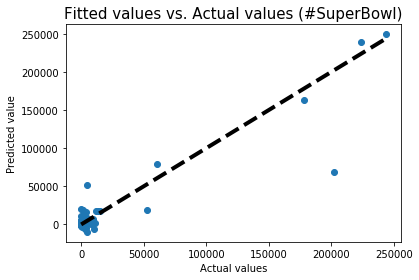

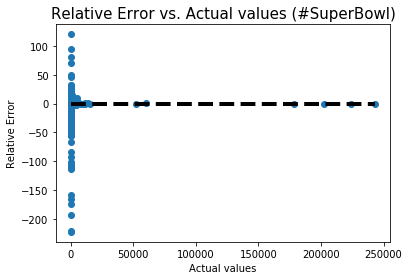

                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     748.6
Date:                Fri, 09 Mar 2018   Prob (F-statistic):          1.76e-250
Time:                        22:57:58   Log-Likelihood:                -5985.3
No. Observations:                 586   AIC:                         1.198e+04
Df Residuals:                     581   BIC:                         1.200e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_tweets          2.2862      0.083     

In [11]:
linear_regression('#GoHawks')
linear_regression('#GoPatriots')
linear_regression('#NFL')
linear_regression('#Patriots')
linear_regression('#SB49')
linear_regression('#SuperBowl')

# Problem 1.3

In [20]:
import os
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [21]:
def extract_information(hashtag):
    hashtag_dict = {'#GoHawks' : ['tweet_data/tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweet_data/tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweet_data/tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweet_data/tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweet_data/tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweet_data/tweets_#superbowl.txt', 1348767]}
    
    time_stamps = [0]*hashtag_dict[hashtag][1]
    is_retweet = [False]*hashtag_dict[hashtag][1]
    followers_of_users = [0]*hashtag_dict[hashtag][1]
    number_of_url_citations = [0]*hashtag_dict[hashtag][1]
    author_names = ['']*hashtag_dict[hashtag][1]

    ranking_scores = [0.0]*hashtag_dict[hashtag][1]
    number_of_hashtags = [0]*hashtag_dict[hashtag][1]
    
    number_of_replis=[0]*hashtag_dict[hashtag][1]
    number_of_impressions=[0]*hashtag_dict[hashtag][1]
    number_of_favorite_count=[0]*hashtag_dict[hashtag][1]
            
    with open(hashtag_dict[hashtag][0],encoding='utf-8') as input_file:
        for (line, index) in zip(input_file, range(0, hashtag_dict[hashtag][1])):
            data = json.loads(line)
            time_stamps[index] = data['citation_date']
            followers_of_users[index] = data['author']['followers']
            
            author_name = data['author']['nick']
            original_author_name = data['original_author']['nick']
            if author_name != original_author_name:
                is_retweet[index] = True
                
            author_names[index] = author_name
            number_of_url_citations[index] = len(data['tweet']['entities']['urls'])
 
            ranking_scores[index] = data['metrics']['ranking_score']
            number_of_hashtags[index] = data['title'].count('#')
            
            number_of_replis[index]=data['metrics']['citations']['replies']
            number_of_impressions[index]=data['metrics']['impressions']
            number_of_favorite_count[index]=data['tweet']['favorite_count']
            # number of 'favourites' the tweet received
    input_file.close()
    
 #-------------------- Calculate related parameters ------------------------

    hours_passed = int((max(time_stamps)-min(time_stamps))/3600)+1
    
    hourly_number_of_tweets = [0] * hours_passed
    hourly_number_of_retweets = [0] * hours_passed
    hourly_sum_of_followers = [0] * hours_passed

    hourly_time_of_the_day = [0] * hours_passed
    hourly_number_of_url_citations = [0] * hours_passed
    hourly_number_of_authors = [0] * hours_passed
       
    hourly_author_set = [0] * hours_passed
    for i in range(0, hours_passed):
        hourly_author_set[i] = set([])


    hourly_total_ranking_scores = [0.0] * hours_passed
    hourly_number_of_hashtags = [0] * hours_passed
    
    hourly_number_of_impressions=[0] * hours_passed
    hourly_number_of_replies=[0] * hours_passed
    hourly_number_of_favorite_count=[0] * hours_passed
    

    start_time = min(time_stamps)
    for i in range(0, len(time_stamps)):
        current_hour = int((time_stamps[i]-start_time)/3600)
        hourly_number_of_tweets[current_hour] += 1
        if is_retweet[i]:
            hourly_number_of_retweets[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_of_users[i]


        hourly_number_of_url_citations[current_hour] += number_of_url_citations[i]
        hourly_author_set[current_hour].add(author_names[i])

        hourly_total_ranking_scores[current_hour] += ranking_scores[i]
        hourly_number_of_hashtags[current_hour] += number_of_hashtags[i]
        
        hourly_number_of_impressions[current_hour] +=number_of_impressions[i]
        hourly_number_of_replies[current_hour] +=number_of_replis[i]
        hourly_number_of_favorite_count[current_hour] +=number_of_favorite_count[i]

    for i in range(0, len(hourly_author_set)):
        hourly_number_of_authors[i] = len(hourly_author_set[i])

    for i in range(0, len(hourly_time_of_the_day)):
        hourly_time_of_the_day[i] = i%24

    #------------------ Build DataFrame and save to file ----------------------

    target_value = hourly_number_of_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_number_of_tweets, hourly_number_of_retweets, hourly_sum_of_followers,
                     hourly_time_of_the_day, hourly_number_of_url_citations, hourly_number_of_authors,
                     hourly_total_ranking_scores, hourly_number_of_hashtags,hourly_number_of_impressions,hourly_number_of_replies,
                     hourly_number_of_favorite_count,target_value])

    data = np.transpose(data)

    df = DataFrame(data)
    df.columns = ['num_tweets', 'num_retweets', 'sum_followers', 'time_of_day', 'num_URLs', 'num_authors', 
                  'ranking_score', 'num_hashtags','num_impressions','num_replies','num_favorites','target_value']

    print(df.head())
    
    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')

    df.to_csv('./Extracted_data/Q3_'+hashtag+'.csv', index = False)   

#==============================================================================
    



In [22]:
#================== Function that performs linear regression===================

def calculate_linear_regression(hashtag):
    training_data = pd.read_csv('./Extracted_data/Q3_'+hashtag+'.csv')

    #--------------------------- Linear Regression ----------------------------

    target_data = training_data.pop('target_value')
       
    lin_reg = LinearRegression(fit_intercept = False)
    lin_reg_result = lin_reg.fit(training_data, target_data)

    predicted_values = lin_reg_result.predict(training_data)
    print('RMSE: ',mean_squared_error(target_data, predicted_values)**0.5)

    #----------------------------- Perform t-test -----------------------------

    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

    #-------------------------- Plot top 3 features ---------------------------

    feature_names = ['num_tweets', 'num_retweets', 'sum_followers', 'time_of_day', 'num_URLs', 'num_authors',
                     'ranking_score', 'num_hashtags', 'num_impressions','num_replies','num_favorites']
    
    # using p_value for feature selection
    # the p_value of a signaficant feature should be lower than 0.05
    best_features = results.pvalues.argsort()[:3]
    print("Best features selected are:")

    for index in best_features:
        print(feature_names[index])
        plt.clf()
        plt.scatter(training_data[feature_names[index]],predicted_values)
        plt.title("Scatter plot for {0} against {1}".format(hashtag, feature_names[index]))
        plt.xlabel(feature_names[index])
        plt.ylabel("Predicted value")
        plt.show()  

#==============================================================================

From observing the significance, or p-value, of each feature, it is evident that the total number of tweets for the current hour is not a statistically significant feature as the p-value is larger than 0.05 (assuming alpha at 0.05). Every other feature, however, shows a low p-value, indicating that it contributes greatly our final prediction, and are therefor valuable features. In general, a low p-value is evidence for the change in the predictor's value to be directly correlated to the change in the response variable, which is what we desire.

Processing hashtag "#GoHawks"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0        31.0           9.0        25181.0          0.0      12.0   
1        14.0           3.0         7860.0          1.0       5.0   
2        13.0           3.0        27313.0          2.0       7.0   
3        14.0           6.0        24619.0          3.0       4.0   
4        27.0           3.0        33511.0          4.0       4.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0         25.0     123.704529          72.0          23385.0          1.0   
1         12.0      54.635073          44.0           7625.0          0.0   
2         12.0      59.577578          47.0          26482.0          0.0   
3         14.0      59.459946          29.0          23538.0          0.0   
4         23.0     112.968746          58.0          32232.0          0.0   

   num_favorites  target_value  
0            0.0          14.0  
1            0.0   

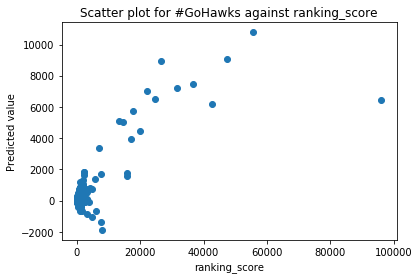

num_tweets


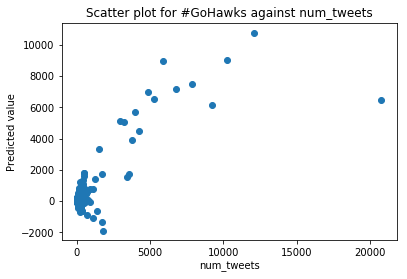

num_URLs


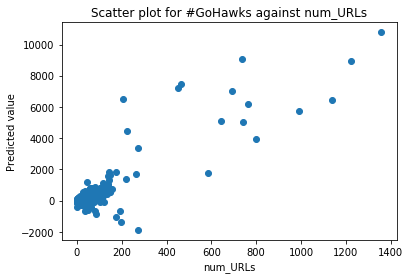

Processing hashtag "#GoPatriots"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0         2.0           0.0        12717.0          0.0       0.0   
1         0.0           0.0            0.0          1.0       0.0   
2         1.0           0.0          568.0          2.0       0.0   
3         3.0           1.0         1065.0          3.0       1.0   
4         2.0           0.0         2850.0          4.0       0.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0          2.0      11.739033           2.0          12520.0          0.0   
1          0.0       0.000000           0.0              0.0          0.0   
2          1.0       4.758774           1.0            552.0          0.0   
3          3.0      12.924486           9.0           1007.0          0.0   
4          1.0       7.767500           3.0           2666.0          0.0   

   num_favorites  target_value  
0            0.0           0.0  
1            0.0

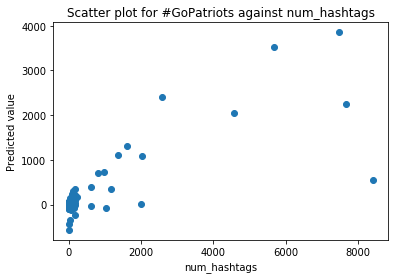

num_URLs


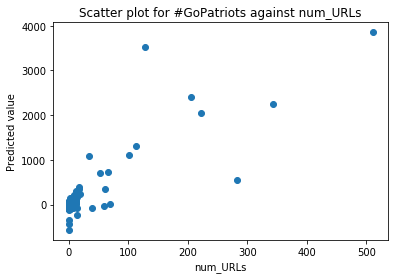

num_replies


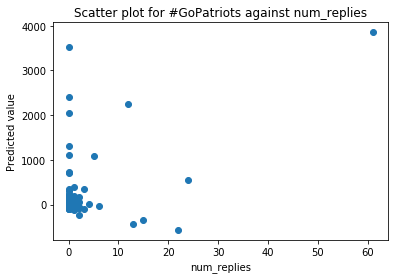

Processing hashtag "#NFL"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0        59.0           0.0       104976.0          0.0      61.0   
1        54.0           1.0       107645.0          1.0      49.0   
2        56.0           1.0       100947.0          2.0      51.0   
3        67.0           1.0       103114.0          3.0      66.0   
4        64.0           2.0       130233.0          4.0      60.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0         32.0     248.259601         202.0         110887.0          0.0   
1         36.0     233.645242         161.0         104625.0          0.0   
2         31.0     230.351732         210.0          96860.0          2.0   
3         44.0     278.703832         229.0          98396.0          0.0   
4         47.0     276.877871         229.0         316813.0          0.0   

   num_favorites  target_value  
0            0.0          54.0  
1            2.0       

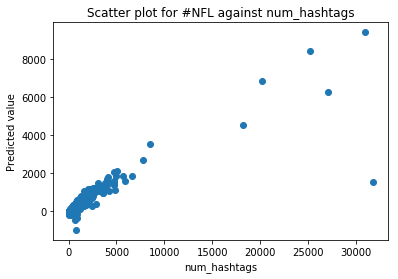

num_authors


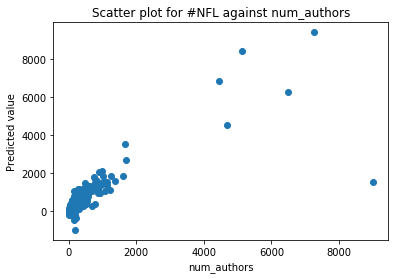

num_favorites


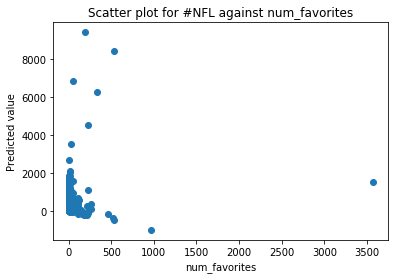

Processing hashtag "#Patriots"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0        26.0           6.0       139752.0          0.0      19.0   
1        26.0           3.0        57868.0          1.0      23.0   
2        28.0           2.0       143706.0          2.0      22.0   
3        23.0           2.0        65844.0          3.0      18.0   
4        50.0           5.0       274809.0          4.0      35.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0         23.0     107.375291          87.0         135162.0          0.0   
1         18.0     110.762924          84.0          55806.0          1.0   
2         23.0     117.671097          98.0         135595.0          0.0   
3         18.0     103.128199          96.0          62556.0          0.0   
4         44.0     232.380632         157.0         287131.0          0.0   

   num_favorites  target_value  
0            0.0          26.0  
1            0.0  

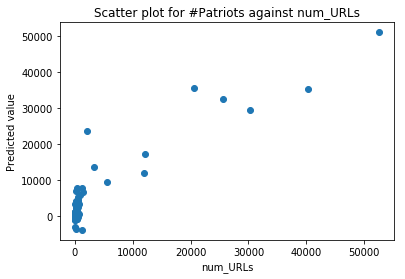

ranking_score


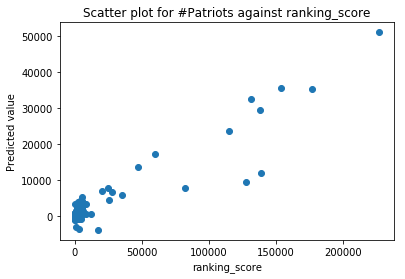

num_tweets


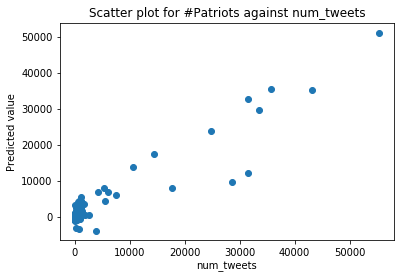

Processing hashtag "#SB49"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0         1.0           0.0           59.0          0.0       0.0   
1         1.0           0.0           21.0          1.0       1.0   
2         4.0           0.0         1407.0          2.0       3.0   
3         2.0           0.0          398.0          3.0       1.0   
4         1.0           0.0          170.0          4.0       0.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0          1.0       4.174798           5.0             69.0          0.0   
1          1.0       3.761640           3.0             21.0          0.0   
2          4.0      15.454219          12.0           1412.0          0.0   
3          2.0       6.939926           8.0             83.0          0.0   
4          1.0       3.032224           2.0            160.0          0.0   

   num_favorites  target_value  
0            0.0           1.0  
1            0.0      

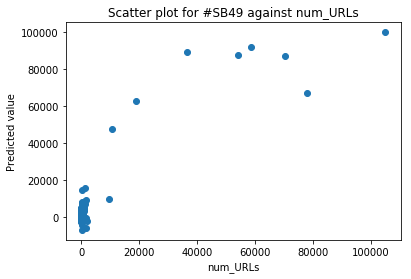

num_tweets


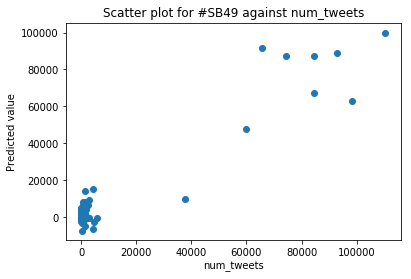

ranking_score


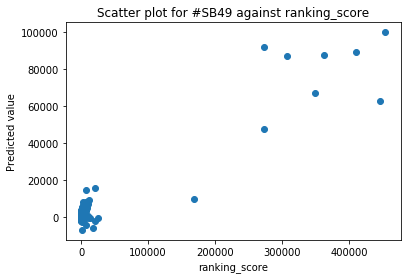

Processing hashtag "#SuperBowl"......

   num_tweets  num_retweets  sum_followers  time_of_day  num_URLs  \
0         8.0           0.0         3181.0          0.0       6.0   
1         9.0           1.0      1375481.0          1.0       4.0   
2        14.0           1.0        44444.0          2.0       6.0   
3        10.0           0.0        34301.0          3.0       9.0   
4        15.0           2.0        21187.0          4.0       7.0   

   num_authors  ranking_score  num_hashtags  num_impressions  num_replies  \
0          7.0      33.149173          20.0           3177.0          0.0   
1          8.0      42.124366          20.0        1335376.0          0.0   
2         14.0      65.333827          27.0          42208.0          0.0   
3         10.0      46.785179          29.0          68126.0          0.0   
4         15.0      66.580391          47.0          18900.0          0.0   

   num_favorites  target_value  
0            0.0           9.0  
1            0.0 

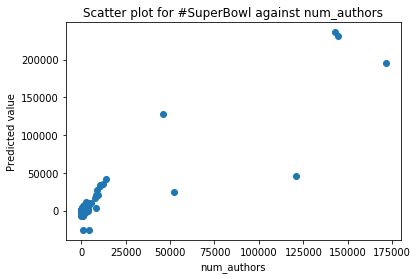

num_tweets


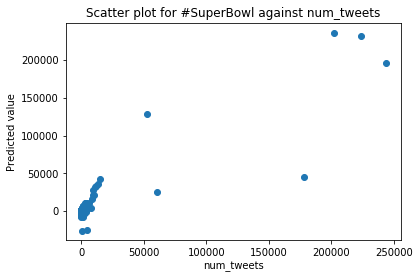

num_favorites


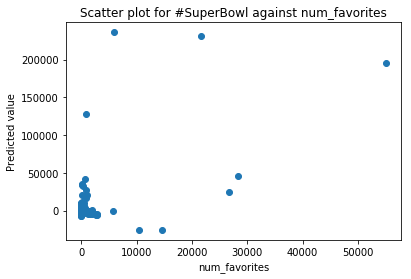

In [23]:
def obtain_data_and_perform_linear_regression(hashtag):
    print('Processing hashtag "' + hashtag + '"......\n')
    extract_information(hashtag)
    calculate_linear_regression(hashtag)

obtain_data_and_perform_linear_regression('#GoHawks')
obtain_data_and_perform_linear_regression('#GoPatriots')
obtain_data_and_perform_linear_regression('#NFL')
obtain_data_and_perform_linear_regression('#Patriots')
obtain_data_and_perform_linear_regression('#SB49')
obtain_data_and_perform_linear_regression('#SuperBowl')

# Problem 1.4 Q1

In [1]:
import os
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cross_validation import cross_val_predict

C:\Users\Shijun\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Shijun\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import datetime
import pytz
pst_tz = pytz.timezone('US/Pacific')
time0=datetime.datetime.fromtimestamp(1421222400, pst_tz)
time1=datetime.datetime.fromtimestamp(1422806400, pst_tz)
time2=datetime.datetime.fromtimestamp(1422849600, pst_tz)
print(time0)
print(time1)
print(time2)

firsttime = int((1422806400-1421222400)/3600)
print(firsttime)
secondtime = int((1422849600-1421222400)/3600)
print(secondtime)

2015-01-14 00:00:00-08:00
2015-02-01 08:00:00-08:00
2015-02-01 20:00:00-08:00
440
452


In [3]:
def extract_information(hashtag):
    print(hashtag)
    hashtag_dict = {'#GoHawks' : ['tweet_data/tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweet_data/tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweet_data/tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweet_data/tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweet_data/tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweet_data/tweets_#superbowl.txt', 1348767]}
    
    time_stamps = [0]*hashtag_dict[hashtag][1]
    is_retweet = [False]*hashtag_dict[hashtag][1]
    followers_of_users = [0]*hashtag_dict[hashtag][1]
    number_of_url_citations = [0]*hashtag_dict[hashtag][1]
    author_names = ['']*hashtag_dict[hashtag][1]
    
    ranking_scores = [0.0]*hashtag_dict[hashtag][1]
    number_of_hashtags = [0]*hashtag_dict[hashtag][1]
            
    number_of_replis=[0]*hashtag_dict[hashtag][1]
    number_of_impressions=[0]*hashtag_dict[hashtag][1]
    number_of_favorite_count=[0]*hashtag_dict[hashtag][1]

    with open(hashtag_dict[hashtag][0],encoding='utf-8') as input_file:
        for (line, index) in zip(input_file, range(0, hashtag_dict[hashtag][1])):
            data = json.loads(line)
            
            time_stamps[index] = data['citation_date']
            followers_of_users[index] = data['author']['followers']
            author_name = data['author']['nick']
            original_author_name = data['original_author']['nick']
            if author_name != original_author_name:
                is_retweet[index] = True
                
            author_names[index] = author_name
            number_of_url_citations[index] = len(data['tweet']['entities']['urls'])
          
            ranking_scores[index] = data['metrics']['ranking_score']
            number_of_hashtags[index] = data['title'].count('#')
         
            number_of_replis[index]=data['metrics']['citations']['replies']
            number_of_impressions[index]=data['metrics']['impressions']
            number_of_favorite_count[index]=data['tweet']['favorite_count']
        
        
    input_file.close()
    
 #-------------------- Calculate related parameters ------------------------

    start_time = 1421222400
    hours_passed = int((max(time_stamps)-start_time)/3600)+1
    
    hourly_number_of_tweets = [0] * hours_passed
    hourly_number_of_retweets = [0] * hours_passed
    hourly_sum_of_followers = [0] * hours_passed
 
    hourly_time_of_the_day = [0] * hours_passed
    hourly_number_of_url_citations = [0] * hours_passed
    hourly_number_of_authors = [0] * hours_passed
    
    hourly_author_set = [0] * hours_passed
    for i in range(0, hours_passed):
        hourly_author_set[i] = set([])

   
    hourly_total_ranking_scores = [0.0] * hours_passed
    hourly_number_of_hashtags = [0] * hours_passed
    
    hourly_number_of_impressions=[0] * hours_passed
    hourly_number_of_replies=[0] * hours_passed
    hourly_number_of_favorite_count=[0] * hours_passed
    
    for i in range(0, len(time_stamps)):
        current_hour = int((time_stamps[i]-start_time)/3600)
        hourly_number_of_tweets[current_hour] += 1
        if is_retweet[i]:
            hourly_number_of_retweets[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_of_users[i]

        hourly_number_of_url_citations[current_hour] += number_of_url_citations[i]
        hourly_author_set[current_hour].add(author_names[i])
   


        hourly_total_ranking_scores[current_hour] += ranking_scores[i]
        hourly_number_of_hashtags[current_hour] += number_of_hashtags[i]
        
              
        hourly_number_of_impressions[current_hour] +=number_of_impressions[i]
        hourly_number_of_replies[current_hour] +=number_of_replis[i]
        hourly_number_of_favorite_count[current_hour] +=number_of_favorite_count[i]

        
        
    for i in range(0, len(hourly_author_set)):
        hourly_number_of_authors[i] = len(hourly_author_set[i])

    for i in range(0, len(hourly_time_of_the_day)):
        hourly_time_of_the_day[i] = i%24

    #------------------ Build DataFrame and save to file ----------------------

    target_value = hourly_number_of_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_number_of_tweets, hourly_number_of_retweets, hourly_sum_of_followers,
                     hourly_time_of_the_day, hourly_number_of_url_citations, hourly_number_of_authors,
                     hourly_total_ranking_scores, hourly_number_of_hashtags,hourly_number_of_impressions,hourly_number_of_replies,
                     hourly_number_of_favorite_count,target_value])
    data = np.transpose(data)

    df = DataFrame(data)
    df.columns = ['num_tweets', 'num_retweets', 'sum_followers', 'time_of_day', 'num_URLs', 'num_authors', 
                  'ranking_score', 'num_hashtags','num_impressions','num_replies','num_favorites','target_value']

    
    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')

    df.to_csv('./Extracted_data/Q4_1_'+hashtag+'.csv', index = False)   

#==============================================================================
    


In [4]:
#======================= Calculate average prediction error ===================

def average_prediction_error(target_data, cross_predicted_values):
    total_error = 0.0
    for (actual, predicted) in zip(target_data, cross_predicted_values):
        total_error += abs(actual - predicted)
    print(total_error/len(target_data))

#==============================================================================


#================== Function that performs cross validation ===================

def calculate_cross_validation(hashtag,model):

    training_data = pd.read_csv('./Extracted_data/Q4_1_'+hashtag+'.csv')

    #---------------------------- One-hot encoding ----------------------------

    time_of_day_set = range(0,24)
    for time_of_day in time_of_day_set:
        time_of_day_column_to_be_added = []
        for time_of_day_item in training_data['time_of_day']:
            if time_of_day_item == time_of_day:
                time_of_day_column_to_be_added.append(1)
            else:
                time_of_day_column_to_be_added.append(0)
        training_data.insert(training_data.shape[1]-1, str(time_of_day)+'th_hour', time_of_day_column_to_be_added)
        
    #--------------------------- Cross Validation for Linear Regression-----------------------------

    training_data.drop('time_of_day', 1, inplace = True)
    target_data = training_data.pop('target_value')
    
    training_data1 = training_data[:440] # Before Feb. 1, 8:00 a.m.
    training_data2 = training_data[440:452] # Between Feb. 1, 8:00 a.m. and 8:00 p.m.
    training_data3 = training_data[452:] # After Feb. 1, 8:00 p.m. 
       
    target_data1 = target_data[:440]
    target_data2 = target_data[440:452]
    target_data3 = target_data[452:]  
    
    if model=="Linear Regression":
        lin_reg = LinearRegression(fit_intercept = False)
        cross_predicted_values1 = cross_val_predict(lin_reg, training_data1, target_data1, cv = 10)
        cross_predicted_values2 = cross_val_predict(lin_reg, training_data2, target_data2, cv = 10)
        cross_predicted_values3 = cross_val_predict(lin_reg, training_data3, target_data3, cv = 10)
        print("Linear Regression")
    elif model=="Random Forest":
        rf = RandomForestRegressor(n_estimators = 20, max_depth = 9)
        cross_predicted_values1 = cross_val_predict(rf, training_data1, target_data1, cv = 10)
        cross_predicted_values2 = cross_val_predict(rf, training_data2, target_data2, cv = 10)
        cross_predicted_values3 = cross_val_predict(rf, training_data3, target_data3, cv = 10)
        print("Random Forest")
    elif model=="Neural Network Regression":
        nn = MLPRegressor()
        cross_predicted_values1 = cross_val_predict(nn, training_data1, target_data1, cv = 10)
        cross_predicted_values2 = cross_val_predict(nn, training_data2, target_data2, cv = 10)
        cross_predicted_values3 = cross_val_predict(nn, training_data3, target_data3, cv = 10)
        print("Neural Network Regression")
    else:
        print("Model select error.")
    
    #-------------------- Calculate average prediction error ------------------

    print('Average prediction error before Feb. 1, 8:00 a.m.:')
    average_prediction_error(target_data1,cross_predicted_values1)

    print('Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:')
    average_prediction_error(target_data2,cross_predicted_values2)

    print('Average prediction error after Feb. 1, 8:00 p.m.:')
    average_prediction_error(target_data3,cross_predicted_values3)


#==============================================================================

In [5]:
def obtain_data_and_perform_cross_validation(hashtag):
    extract_information(hashtag)
    calculate_cross_validation(hashtag,"Linear Regression")
    calculate_cross_validation(hashtag,"Random Forest")
    calculate_cross_validation(hashtag,"Neural Network Regression")


In [6]:
obtain_data_and_perform_cross_validation('#GoHawks')

#GoHawks
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
382.938082872
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
33620.9050629
Average prediction error after Feb. 1, 8:00 p.m.:
655.707532877
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
158.223677521
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
2394.54166667
Average prediction error after Feb. 1, 8:00 p.m.:
21.6498718478
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
23159.8798728
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
367090.954306
Average prediction error after Feb. 1, 8:00 p.m.:
4071.14410201


In [7]:
obtain_data_and_perform_cross_validation('#GoPatriots')

#GoPatriots
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
16.3551832149
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
3615.48444776
Average prediction error after Feb. 1, 8:00 p.m.:
11.4417400889
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
11.6856160262
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
1048.71666667
Average prediction error after Feb. 1, 8:00 p.m.:
4.21229873741
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
1384.58270496
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
51224.9468102
Average prediction error after Feb. 1, 8:00 p.m.:
39.9734848497


In [8]:
obtain_data_and_perform_cross_validation('#NFL')

#NFL
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
139.731104755
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
43732.1531037
Average prediction error after Feb. 1, 8:00 p.m.:
166.624744865
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
118.211935147
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
2677.87083333
Average prediction error after Feb. 1, 8:00 p.m.:
156.939845604
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
35829.1813524
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
673375.004267
Average prediction error after Feb. 1, 8:00 p.m.:
58673.1270998


In [9]:
obtain_data_and_perform_cross_validation('#Patriots')

#Patriots
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
366.41671288
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
260206.408102
Average prediction error after Feb. 1, 8:00 p.m.:
140.045181373
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
228.503378529
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
18541.075
Average prediction error after Feb. 1, 8:00 p.m.:
103.655390626
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
82071.863165
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
1615059.63943
Average prediction error after Feb. 1, 8:00 p.m.:
52355.0145197


In [10]:
obtain_data_and_perform_cross_validation('#SB49')

#SB49
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
60.2411769951
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
711787.495157
Average prediction error after Feb. 1, 8:00 p.m.:
170.145887833
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
46.9036764564
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
25481.4583333
Average prediction error after Feb. 1, 8:00 p.m.:
107.591412461
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
92165.9467561
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
12643222.7042
Average prediction error after Feb. 1, 8:00 p.m.:
421477.450334


In [11]:
obtain_data_and_perform_cross_validation('#SuperBowl')

#SuperBowl
Linear Regression
Average prediction error before Feb. 1, 8:00 a.m.:
402.905644443
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
443182.646265
Average prediction error after Feb. 1, 8:00 p.m.:
661.99963057
Random Forest
Average prediction error before Feb. 1, 8:00 a.m.:
286.593511542
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
64885.2625
Average prediction error after Feb. 1, 8:00 p.m.:
315.522825538
Neural Network Regression
Average prediction error before Feb. 1, 8:00 a.m.:
291470.50594
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
22211103.3068
Average prediction error after Feb. 1, 8:00 p.m.:
402944.425741


# Problem 1.4 Q2

In [12]:
filenames = ['tweet_data/tweets_#gohawks.txt', 
             'tweet_data/tweets_#gopatriots.txt',
             'tweet_data/tweets_#nfl.txt',
             'tweet_data/tweets_#patriots.txt',
             'tweet_data/tweets_#sb49.txt',
             'tweet_data/tweets_#superbowl.txt']

# aggregate the training data
outfile_length = 0
with open('tweet_data/output_file.txt','w',encoding='utf-8') as outfile:
    for fname in filenames:
        with open(fname,encoding='utf-8') as infile:
            for line in infile:
                outfile.write(line)
                outfile_length+=1
print(outfile_length)

3138823


In [13]:
def extract_information(outfile,outfile_length): 
    time_stamps = [0]*outfile_length
    is_retweet = [False]*outfile_length
    followers_of_users = [0]*outfile_length
    number_of_url_citations = [0]*outfile_length
    author_names = ['']*outfile_length
   
    ranking_scores = [0.0]*outfile_length
    number_of_hashtags = [0]*outfile_length
    
    number_of_replis=[0]*outfile_length
    number_of_impressions=[0]*outfile_length
    number_of_favorite_count=[0]*outfile_length
    
    
    with open(outfile,encoding='utf-8') as input_file:
        for (line, index) in zip(input_file, range(0, outfile_length)):
            data = json.loads(line)
            time_stamps[index] = data['citation_date']
            followers_of_users[index] = data['author']['followers']
            author_name = data['author']['nick']
            original_author_name = data['original_author']['nick']
            if author_name != original_author_name:
                is_retweet[index] = True
                
            author_names[index] = author_name
            number_of_url_citations[index] = len(data['tweet']['entities']['urls'])
            
            ranking_scores[index] = data['metrics']['ranking_score']
            number_of_hashtags[index] = data['title'].count('#')
            
            number_of_replis[index]=data['metrics']['citations']['replies']
            number_of_impressions[index]=data['metrics']['impressions']
            number_of_favorite_count[index]=data['tweet']['favorite_count']
    input_file.close()
    
 #-------------------- Calculate related parameters ------------------------

    start_time = 1421222400
    hours_passed = int((max(time_stamps)-start_time)/3600)+1
    
    hourly_number_of_tweets = [0] * hours_passed
    hourly_number_of_retweets = [0] * hours_passed
    hourly_sum_of_followers = [0] * hours_passed
   
    hourly_time_of_the_day = [0] * hours_passed
    hourly_number_of_url_citations = [0] * hours_passed
    hourly_number_of_authors = [0] * hours_passed
    
    
    hourly_author_set = [0] * hours_passed
    for i in range(0, hours_passed):
        hourly_author_set[i] = set([])

    
    hourly_total_ranking_scores = [0.0] * hours_passed
    hourly_number_of_hashtags = [0] * hours_passed
    
    hourly_number_of_impressions=[0] * hours_passed
    hourly_number_of_replies=[0] * hours_passed
    hourly_number_of_favorite_count=[0] * hours_passed
    
    
    for i in range(0, len(time_stamps)):
        current_hour = int((time_stamps[i]-start_time)/3600)
        hourly_number_of_tweets[current_hour] += 1
        if is_retweet[i]:
            hourly_number_of_retweets[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_of_users[i]
       
        hourly_number_of_url_citations[current_hour] += number_of_url_citations[i]
        hourly_author_set[current_hour].add(author_names[i])
       
        hourly_total_ranking_scores[current_hour] += ranking_scores[i]
        hourly_number_of_hashtags[current_hour] += number_of_hashtags[i]
        
        hourly_number_of_impressions[current_hour] +=number_of_impressions[i]
        hourly_number_of_replies[current_hour] +=number_of_replis[i]
        hourly_number_of_favorite_count[current_hour] +=number_of_favorite_count[i]

        
        
        
    for i in range(0, len(hourly_author_set)):
        hourly_number_of_authors[i] = len(hourly_author_set[i])

    for i in range(0, len(hourly_time_of_the_day)):
        hourly_time_of_the_day[i] = i%24

    #------------------ Build DataFrame and save to file ----------------------

    target_value = hourly_number_of_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_number_of_tweets, hourly_number_of_retweets, hourly_sum_of_followers,
                     hourly_time_of_the_day, hourly_number_of_url_citations, hourly_number_of_authors,
                     hourly_total_ranking_scores, hourly_number_of_hashtags,hourly_number_of_impressions,hourly_number_of_replies,
                     hourly_number_of_favorite_count,target_value])


    data = np.transpose(data)

    df = DataFrame(data)
    df.columns = ['num_tweets', 'num_retweets', 'sum_followers', 'time_of_day', 'num_URLs', 'num_authors', 
                  'ranking_score', 'num_hashtags','num_impressions','num_replies','num_favorites','target_value']

    
    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')

    df.to_csv('./Extracted_data/Q4_2.csv', index = False)   

#==============================================================================
    


In [14]:
#======================= Calculate average prediction error ===================

def average_prediction_error(target_data, cross_predicted_values):
    total_error = 0.0
    for (actual, predicted) in zip(target_data, cross_predicted_values):
        total_error += abs(actual - predicted)
    print(total_error/len(target_data))

#==============================================================================


#================== Function that performs cross validation ===================

def calculate_cross_validation(outfile):

    training_data = pd.read_csv('./Extracted_data/Q4_2.csv')

    #---------------------------- One-hot encoding ----------------------------

    time_of_day_set = range(0,24)
    for time_of_day in time_of_day_set:
        time_of_day_column_to_be_added = []
        for time_of_day_item in training_data['time_of_day']:
            if time_of_day_item == time_of_day:
                time_of_day_column_to_be_added.append(1)
            else:
                time_of_day_column_to_be_added.append(0)
        training_data.insert(training_data.shape[1]-1, str(time_of_day)+'th_hour', time_of_day_column_to_be_added)
        
    #--------------------------- Cross Validation -----------------------------

    training_data.drop('time_of_day', 1, inplace = True)
    target_data = training_data.pop('target_value')
    
    training_data1 = training_data[:440] # Before Feb. 1, 8:00 a.m.
    training_data2 = training_data[440:452] # Between Feb. 1, 8:00 a.m. and 8:00 p.m.
    training_data3 = training_data[452:] # After Feb. 1, 8:00 p.m. 
       
    target_data1 = target_data[:440]
    target_data2 = target_data[440:452]
    target_data3 = target_data[452:]  
 
    print("Random Forest Regression")
    rf = RandomForestRegressor(n_estimators = 20, max_depth = 9)
    cross_predicted_values1 = cross_val_predict(rf, training_data1, target_data1, cv = 10)
    cross_predicted_values2 = cross_val_predict(rf, training_data2, target_data2, cv = 10)
    cross_predicted_values3 = cross_val_predict(rf, training_data3, target_data3, cv = 10)

    #-------------------- Calculate average prediction error ------------------

    print('Average prediction error before Feb. 1, 8:00 a.m.:')
    average_prediction_error(target_data1,cross_predicted_values1)

    print('Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:')
    average_prediction_error(target_data2,cross_predicted_values2)

    print('Average prediction error after Feb. 1, 8:00 p.m.:')
    average_prediction_error(target_data3,cross_predicted_values3)


#==============================================================================

In [15]:
extract_information('tweet_data/output_file.txt',outfile_length)
calculate_cross_validation(outfile)

Random Forest Regression
Average prediction error before Feb. 1, 8:00 a.m.:
641.737559025
Average prediction error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
108418.645833
Average prediction error after Feb. 1, 8:00 p.m.:
423.51172967
